# Content with notebooks



In [1]:
# Librería
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Configuración
sns.set_style("darkgrid")

In [2]:
# Cargar datos
data = pd.read_csv('../data/s1/e1/u1/template_session.txt', sep=';', header=0)

# Convertir el índice de tiempo en una serie temporal
data['Time'] = data['time index'].apply(lambda x : 0.04 * (x - 1))
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.set_index('Time', inplace=True)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2187 entries, 1970-01-01 00:00:00 to 1970-01-01 00:01:27.440000
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time index  2187 non-null   int64  
 1   acc_x       2187 non-null   float64
 2   acc_y       2187 non-null   float64
 3   acc_z       2187 non-null   float64
 4   gyr_x       2187 non-null   float64
 5   gyr_y       2187 non-null   float64
 6   gyr_z       2187 non-null   float64
 7   mag_x       2187 non-null   float64
 8   mag_y       2187 non-null   float64
 9   mag_z       2187 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 187.9 KB


In [4]:
data.describe()

,time index,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z
count,2187.00000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000
mean,1094.00000,-9.650344,-1.708560,0.358899,-0.009140,0.003948,-0.003619,0.587005,0.459447,-0.069092
std,631.47684,0.018198,0.040236,0.091909,0.008695,0.010083,0.009880,0.000995,0.001836,0.008427
min,1.00000,-9.737950,-1.867905,0.145510,-0.045980,-0.117151,-0.048818,0.583877,0.449843,-0.095467
25%,547.50000,-9.664517,-1.733209,0.291209,-0.014658,-0.001411,-0.009025,0.586377,0.458565,-0.072547
50%,1094.00000,-9.649331,-1.709512,0.339248,-0.008752,0.003578,-0.003705,0.587026,0.459626,-0.066377
75%,1640.50000,-9.636648,-1.687501,0.399008,-0.003765,0.009827,0.001950,0.587681,0.460677,-0.062729
max,2187.00000,-9.580574,-1.498625,0.737426,0.024021,0.045480,0.048261,0.590741,0.464380,-0.057091


## EDA

In [21]:
timeserie = data["acc_x"]

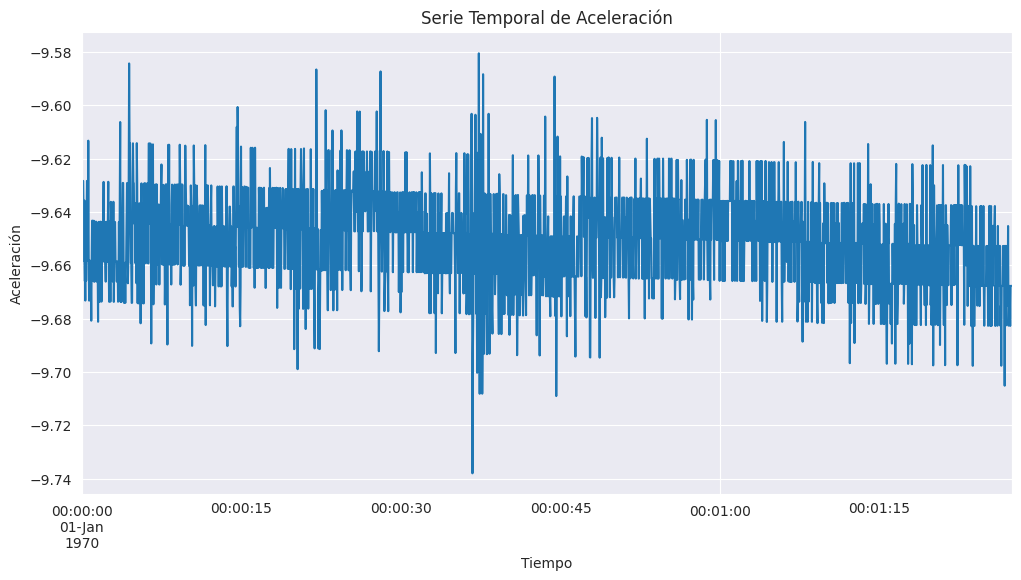

In [22]:
timeserie.plot(figsize=(12, 6))
plt.title('Serie Temporal de Aceleración')
plt.xlabel('Tiempo')
plt.ylabel('Aceleración')
plt.show()

### Normalidad

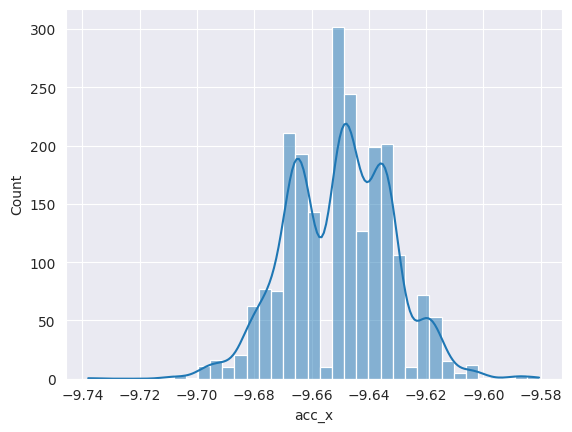

In [23]:
sns.histplot(timeserie, kde=True);

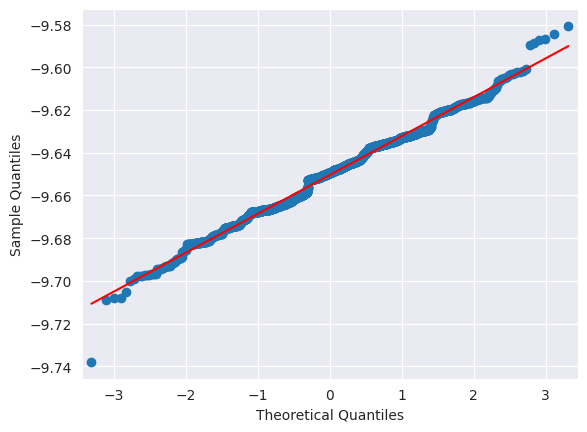

In [24]:
qqplot(timeserie, line='s');

In [25]:
from scipy.stats import shapiro

print('Shapiro-Wilk Test:')
stat, p = shapiro(timeserie)
print('Statistics=%.6f, p=%e' % (stat, p))

alpha = 0.05
if p > alpha:
 print('Sample looks Normal (fail to reject H0)')
else:
 print('Sample does not look Normal (reject H0)')

Shapiro-Wilk Test:
Statistics=0.991685, p=7.327696e-10
Sample does not look Normal (reject H0)


In [26]:
import numpy as np
from scipy import stats

print('Kolmogorov-Smirnov:')
stat, p = stats.kstest(timeserie, stats.norm.cdf)
print('Statistics=%.6f, p=%e' % (stat, p))

alpha = 0.05
if p > alpha:
 print('Sample looks Normal (fail to reject H0)')
else:
 print('Sample does not look Normal (reject H0)')

Kolmogorov-Smirnov:
Statistics=1.000000, p=0.000000e+00
Sample does not look Normal (reject H0)


In [27]:
frecuencia = pd.infer_freq(data.index)
print("Frecuencia: ", frecuencia)

Frecuencia:  40ms


### Descomposición

#### Linealidad

In [35]:
from sklearn.linear_model import LinearRegression
import numpy as np


trend_model = LinearRegression(fit_intercept=True)
trend_model.fit(np.arange(data.shape[0]).reshape((-1,1)), timeserie)

LinearRegression()

<Axes: xlabel='Time'>

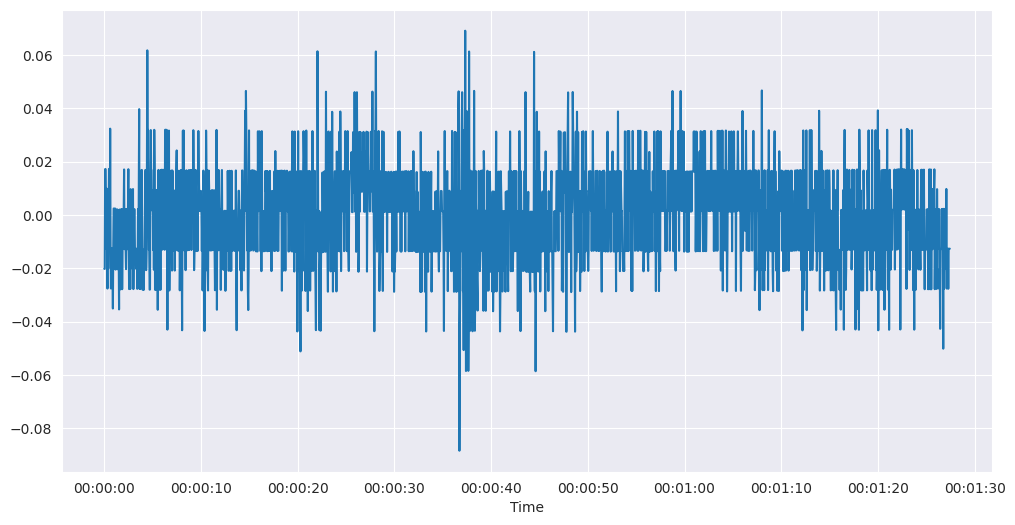

In [36]:
residuals = np.array(timeserie) - trend_model.predict(np.arange(data.shape[0]).reshape((-1,1)))

plt.figure(figsize=(12, 6))
sns.lineplot(y=residuals, x=data.index)

#### Estacionalidad

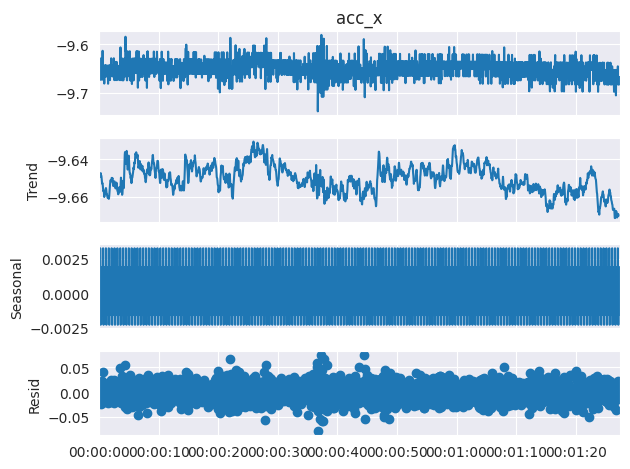

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(timeserie)
fig = decomposition.plot()
plt.show()

## Estacionario

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

def plotds(xt, nlag=30, fig_size=(12, 10)):
    
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf = plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=50, ax=ax_acf)
    plot_pacf(xt, lags=50, ax=ax_pacf)
    plt.tight_layout()
    
    return None

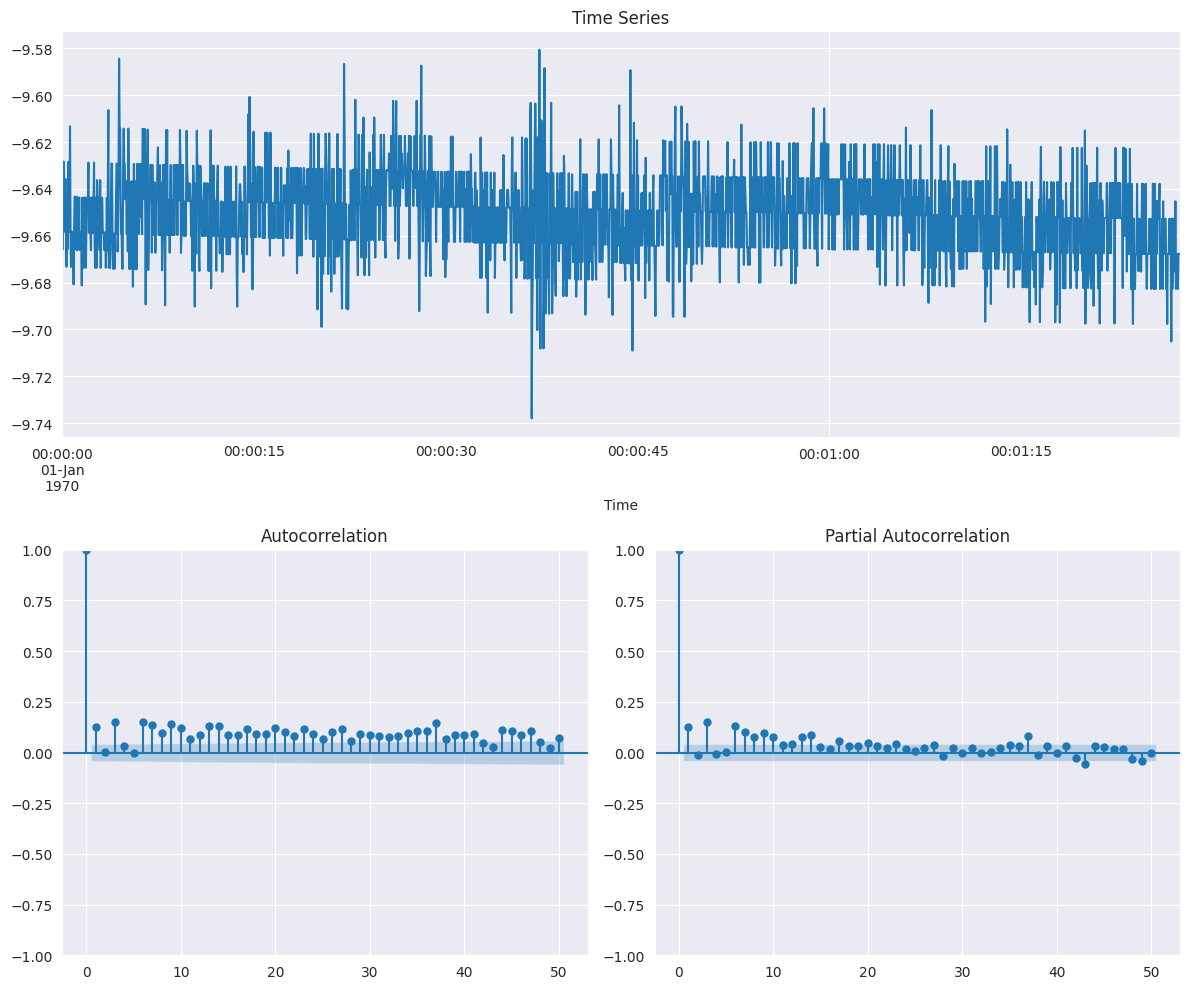

In [45]:
plotds(timeserie)